# Preliminaries

## Libraries
We use scikit-learn library to achieve goals in task 1 & task 2. In addition, we use networkx library to perform propensity score matching at task 1.

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import itertools
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx

## Theme for plots
Overall, we use seaborn to plot graphs and charts. We pick whitegrid for simplicity.

In [2]:
sns.set(style="whitegrid")

## Predefined Functions
We define six functions reduce the number of lines of code especially in task 1 and provide reusability.

#### 1. Splitting Dataset into two group based on treat or not
* Simply divide the dataset based on value on treat column.

In [3]:
def split_data(df):
    return df.loc[df["treat"]==1], df.loc[df["treat"]==0]

#### 2. Plotting Continuous Features Distribution
* Draw distribution of each continuous feature (age, educ, re74, and re75) in treated and control group
* This will result 4 plots with 2 charts each.

In [4]:
def plot_continuous_features_distribution(df_treat_group, df_control_group):
    # Plot 2 x 2
    fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(16, 12)
    
    # Draw distribution of age
    ax1 = sns.distplot(df_treat_group['age'], ax=ax1)
    ax1 = sns.distplot(df_control_group['age'], ax=ax1)
    ax1.set_title("Distribution of Age in Treated (Blue) and Control(Green)")

    # Draw distribution of years of education
    ax2 = sns.distplot(df_treat_group['educ'], ax=ax2)
    ax2 = sns.distplot(df_control_group['educ'], ax=ax2)
    ax2.set_title("Distribution of Years of Education in Treated (Blue) and Control(Green)")

    # Draw distribution of earnings in 1974
    ax3 = sns.distplot(df_treat_group['re74'], ax=ax3)
    ax3 = sns.distplot(df_control_group['re74'], ax=ax3)
    ax3.set_title("Distribution of Earings 1975 in Treated (Blue) and Control(Green)")

    # Draw distribution of earnings in 1975
    ax4 = sns.distplot(df_treat_group['re75'], ax=ax4)
    ax4 = sns.distplot(df_control_group['re75'], ax=ax4)
    ax4.set_title("Distribution of Earings 1975 in Treated (Blue) and Control(Green)")

#### 3. Getting the percentages of each binary feature within dataset
* Account the percentage of each binary features (race [black, white, hispan], married, nodegree) within dataset.
* The corresponding result will be returned in panda dataframe object

In [5]:
def get_binary_features_distribution(df_treat_group, df_control_group):
    # Get the number of subjects for each group
    n_treated = df_treat_group.shape[0]
    n_control = df_control_group.shape[0]
    
    # gather the number of black, white, hispan, married, and nodegree subjects for both treated and control group
    n_black_treated    = df_treat_group.loc[df_treat_group["black"]==1].shape[0]
    n_black_control    = df_control_group.loc[df_control_group["black"]==1].shape[0]
    n_white_treated    = df_treat_group.loc[(df_treat_group["hispan"]==0) & (df_treat_group["black"]==0)].shape[0]
    n_white_control    = df_control_group.loc[(df_control_group["hispan"]==0) & (df_control_group["black"]==0)].shape[0]
    n_hispan_treated   = df_treat_group.loc[df_treat_group["hispan"]==1].shape[0]
    n_hispan_control   = df_control_group.loc[df_control_group["hispan"]==1].shape[0]
    n_married_treated  = df_treat_group.loc[df_treat_group["married"]==1].shape[0]
    n_married_control  = df_control_group.loc[df_control_group["married"]==1].shape[0]
    n_nodegree_treated = df_treat_group.loc[df_treat_group["nodegree"]==1].shape[0]
    n_nodegree_control = df_control_group.loc[df_control_group["nodegree"]==1].shape[0]

    # print the number of each feature
    print("Number of Black Subject in Treated Group: ",n_black_treated)
    print("Number of Black Subject in Control Group: ",n_black_control)
    print("Number of White Subject in Treated Group After Matching: ",n_white_treated)
    print("Number of White Subject in Control Group After Matching: ",n_white_control)
    print("Number of Hispan Subject in Treated Group: ",n_hispan_treated)
    print("Number of Hispan Subject in Control Group: ",n_hispan_control)
    print("Number of Married Subject in Treated Group: ",n_married_treated)
    print("Number of Married Subject in Control Group: ",n_married_control)
    print("Number of Nodegree Subject in Treated Group: ",n_nodegree_treated)
    print("Number of Nodegree Subject in Control Group: ",n_nodegree_control)
    
    # percentage_of_feature = count(features) / n_data
    pr_black_treated    = n_black_treated    / n_treated
    pr_black_control    = n_black_control    / n_control
    pr_white_treated    = n_white_treated    / n_treated
    pr_white_control    = n_white_control    / n_control
    pr_hispan_treated   = n_hispan_treated   / n_treated
    pr_hispan_control   = n_hispan_control   / n_control
    pr_married_treated  = n_married_treated  / n_treated
    pr_married_control  = n_married_control  / n_control
    pr_nodegree_treated = n_nodegree_treated / n_treated
    pr_nodegree_control = n_nodegree_control / n_control
    
    data = {
        'features':['black','hispan','white', 'married', 'not married', 'non degree', 'with degree'],
        'pr_treated':[pr_black_treated, pr_hispan_treated, pr_white_treated, \
                      pr_married_treated, 1 - pr_married_treated, \
                      pr_nodegree_treated, 1 - pr_nodegree_treated],
        'pr_control':[pr_black_control, pr_hispan_control, pr_white_control, \
                      pr_married_control, 1 - pr_married_control, \
                      pr_nodegree_control, 1 - pr_nodegree_control]
       }
    
    # form dataframe of percentage of binary features (race, married, nodegree)
    df_categorical_features_pr = (pd.DataFrame(data, columns = ['features', 'pr_treated', 'pr_control']))
    display(df_categorical_features_pr[0:3])
    display(df_categorical_features_pr[3:5])
    display(df_categorical_features_pr[5:])
    
    return df_categorical_features_pr

#### 4. Plotting binary features distribution
* Draw distribution of each binary feature (race [black, white, hispan], married, and nodegree) in treated and control group
* This will result 1 figure with 3 plot distributions.

In [6]:
# function for ploting each distribution
# use bar chart to depict percentage of binary values in dataset
def add_subplot(data, position, title_):
    ax = data.sort_values(["pr_treated"]) \
                          .plot.bar(ax = position, y=["pr_treated","pr_control"],x=["features"], figsize=(20,4), rot = 0)
    ax.set_xlabel('Percentage of Features');
    ax.set_ylabel('Percentage of Features');
    ax.set_title(title_);

# call this function to plot binary features
def plot_binary_features_distribution(df_categorical_features_pr):
    # create subplot
    fig, axes = plt.subplots(nrows=1, ncols=3)

    # first, let's plot the distribution of race
    add_subplot(df_categorical_features_pr[0:3], 
                axes[0],
                'Percentage of Race in Treated Group and Control Group'
                )

    # second, let's plot the distribution of marriage
    add_subplot(df_categorical_features_pr[3:5], 
                axes[1],
                'Percentage of Marriage in Treated Group and Control Group'
                )

    # third, let's plot the degree
    add_subplot(df_categorical_features_pr[5:7], 
                axes[2],
                'Percentage of School Degree in Treated Group and Control Group'
                )

#### 5. Matching the pair control-treated subject with networkx
* Use networkx graph package to perform max_weight_matching based on "costs" between control and treated subject.
* Assign the matching result into dataframe and return the dataframe

In [7]:
def graph_matching(df_with_costs):
    # Build empty graph
    G = nx.Graph()

    # Build graph with vertices sources, destinations, and distance obtained directly from panda dataframe
    G = nx.from_pandas_dataframe(df_with_costs, '0', 'b', ['costs'])

    # Perform max weight matching
    match_control_treated = nx.max_weight_matching(G, maxcardinality=True)
    
    # Build dataframe from tree result, containing matching pair treated-control subject
    df_prop_matched            = pd.DataFrame(columns=["control","treated"])
    df_prop_matched['treated'] = match_control_treated.keys()
    df_prop_matched['control'] = match_control_treated.values()

    # The dataframe contains redundant entries, e.g. PSID1 - NSW185, NSW185 - PSID1
    # So we sort the values and only pick the first half
    n_treated       = int((df_prop_matched.shape[0])/2)
    df_prop_matched = df_prop_matched.sort_values(by="treated")[:n_treated]

    return df_prop_matched

#### 6. Plotting distribution of earnings outcome (re78) 
* Plot the earnings outcome with boxplot
* Use the boxplots to compare earnings between treated and control group

In [8]:
def plot_re78_distribution(df, str_flag=""):
    # draw 1 x 2 plot
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    fig.set_size_inches(8, 8)
    ax1 = sns.boxplot(y = 're78_control' , data=df, ax = ax1, palette="Set3", showfliers=False)
    ax1.set_title("Real earnings in 1978 for Control Group")

    ax2 = sns.boxplot(y = 're78_treated' , data=df, ax = ax2, palette="Set3", showfliers=False)
    ax2.set_title("Real earnings in 1978 for Treated Group")

    print("Average earning of Control group " + str_flag + ": ",df['re78_control'].mean())
    print("Median earning of Control group " + str_flag + ": ",df['re78_control'].median())
    print("Average earning of Treated group " + str_flag + ": ",df['re78_treated'].mean())
    print("Median earning of Treated group " + str_flag + ": ",df['re78_treated'].median())

# Main Homework

## 1. Propensity Score Matching

Read data from the provided dataset and form raw dataframe.

In [9]:
# df_raw: bulk classic dataset from Robert LaLonde's study 
dataset_file = 'lalonde.csv'
df_raw       = pd.read_csv(dataset_file)

# print general information of the datasets
print("Number of subjects: ",df_raw.shape[0])

# preview the data
display(df_raw.head(5))

Number of subjects:  614


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1a. Naive Analysis

First, we split data into two groups, treatment and control, based on treatment on subject or not (treat 1 or 0)

In [10]:
# split using predefined function split_data
def split_data(df):
    return df.loc[df["treat"]==1], df.loc[df["treat"]==0]

df_treated_raw, df_control_raw = split_data(df_raw)

# print number of treated and control subjects
print("Number of treated subjects: ",df_treated_raw.shape[0])
print("Number of control subjects: ",df_control_raw.shape[0])

Number of treated subjects:  185
Number of control subjects:  429


* We discover that zeros are frequently presence in re78 column. Zeros mean unemployed condition (no salaries) and thus we cannot really analyze the results of job training program. Because we strictly rely with real earnings in 1978 to determine the outcome of job training program, there will be some cases where we decide to ignore zeros.
* Hence we create dataframes with zeros replaces with NaN. By default, pandas operation will not include zeros entries and we can count statistics of the rest non-zeros values.

In [11]:
# we don't want to account for zero, thus we show the dataframe with NaN
# note that this replaces binaries features as well, but we can ignore that since here at this point we focus on re78
df_treated_with_nan    = df_treated_raw.replace(0,np.NAN)
df_control_with_nan    = df_control_raw.replace(0,np.NAN)

Then, we compare 4 different statistics of re78:
1. Earnings in 78 of **treated group (NSW)**
2. Earnings in 78 of **control group (PSID)**
3. Earnings in 78 of **treated group (NSW)**, employed subject only (ignore subject with zeros earnings)
4. Earnings in 78 of **control group (PSID)**, employed subject only (ignore subject with zeros earnings)

In [12]:
print("Re78 statistics of Treated vs Control Group")

# form stats dataframe
stats         = pd.DataFrame(df_treated_raw.describe()[['re78']])
stats.columns = ["treated_re78"]

# add statistics of re78
stats["control_re78"]                     = df_control_raw.describe()[['re78']]
stats["treated_re78_without_unemployed"]  = df_treated_with_nan.describe()[['re78']]
stats["control_re78_without_unemployed"]  = df_control_with_nan.describe()[['re78']]

display(stats)

Re78 statistics of Treated vs Control Group


,treated_re78,control_re78,treated_re78_without_unemployed,control_re78_without_unemployed
count,185.000000,429.000000,140.000000,331.000000
mean,6349.143530,6984.169742,8389.939665,9051.990391
std,7867.402218,7294.161791,8042.944693,7087.340468
min,0.000000,0.000000,289.789900,31.032260
25%,485.229800,220.181300,3167.353750,2978.358000
50%,4232.309000,4975.505000,6504.144500,7310.313000
75%,9642.999000,11688.820000,11017.730000,14131.500000
max,60307.930000,25564.670000,60307.930000,25564.670000


#### Distribution of re78 between two groups - Include outliers and zeros (unemployed subjects)
Now we want to see the distributions of outcome variable re78 between two groups.
<br>First we see the distributions when we include zeros and outliers

Mean earnings in 1978 of Treated group:  6349.143530270269
Median earnings in 1978 of Treated group:  4232.309
Mean earnings in 1978 of Control group:  6984.169742307697
Median earnings in 1978 of Control group:  4975.505


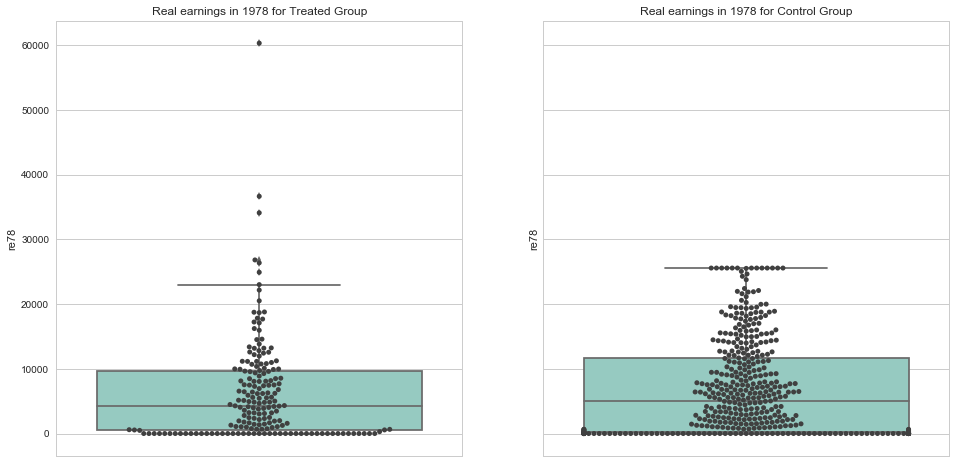

In [13]:
# Plot 2 x 1
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 8)
ax1 = sns.boxplot(y = 're78', data=df_treated_raw, ax = ax1, palette="Set3")
ax1 = sns.swarmplot(y = 're78', data=df_treated_raw, ax = ax1, color=".25")
ax1.set_title("Real earnings in 1978 for Treated Group")

ax2 = sns.boxplot(y = 're78', data=df_control_raw, ax = ax2, palette="Set3")
ax2 = sns.swarmplot(y = 're78', data=df_control_raw, ax = ax2, color=".25")
ax2.set_title("Real earnings in 1978 for Control Group")

# Print mean and median of re78 between two groups
print("Mean earnings in 1978 of Treated group: ", df_treated_raw['re78'].mean())
print("Median earnings in 1978 of Treated group: ", df_treated_raw['re78'].median())
print("Mean earnings in 1978 of Control group: ", df_control_raw['re78'].mean())
print("Median earnings in 1978 of Control group: ", df_control_raw['re78'].median())

#### Observing outliers in treated group & zeros earnings in both group
As we can see in above figure, there are several outliers in treated group with earnings at least 5 times larger than the average group earnings.

In [14]:
# consider outliers are ones with re78 > 5*mean(re78)
df_treated_raw_outliers = df_treated_raw.loc[df_treated_raw['re78'] > 5 * stats.loc["mean"]["treated_re78"]]

# inspect zeros
n_zeros_treated_raw = df_treated_raw.loc[df_treated_raw["re78"]==0].shape[0]
n_zeros_control_raw = df_control_raw.loc[df_control_raw["re78"]==0].shape[0]

# Print brief information about outliers and zeros
print("Number of outliers in treated group: ", df_treated_raw_outliers.shape[0])
print("Number of zeros earnings in 1978 of treated group: ", n_zeros_treated_raw)
print("Number of zeros earnings in 1978 of control group: ", n_zeros_control_raw)

# Display the outliers
display(df_treated_raw_outliers.head(5))

Number of outliers in treated group:  3
Number of zeros earnings in 1978 of treated group:  45
Number of zeros earnings in 1978 of control group:  98


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
106,NSW107,1,27,13,1,0,0,0,0.00,0.000,34099.28
131,NSW132,1,28,11,1,0,0,1,0.00,1284.079,60307.93
181,NSW182,1,25,14,1,0,1,0,35040.07,11536.570,36646.95


It is astonishing to see **45 out of 185** and **98 out of 429** (almost quarter each) subjects in treated group  and control group are unemployed persons. Thus this bold our reason to plot only non-zeros values of re78.

#### Distribution of re78 between two groups - Exclude outliers and zeros (unemployed subjects)
Then let's see the distributions when we exclude zeros and outliers from both group

Average earnings in 1978 of Treated group (zeros excluded):  8389.939665
Median earnings in 1978 of Treated group (zeros excluded):  6504.144499999999
Average earnings in 1978 of Control group (zeros excluded):  9051.990391087618
Median earnings in 1978 of Control group (zeros excluded):  7310.313


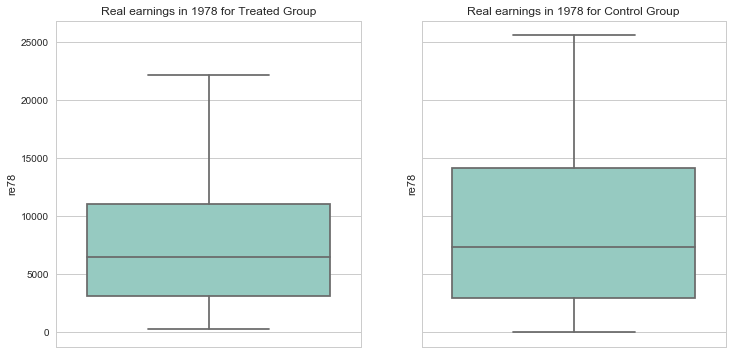

In [15]:
# Plot 2 x 1
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 6)
ax1 = sns.boxplot(y = 're78' , data=df_treated_with_nan, ax = ax1, palette="Set3", showfliers=False)
ax1.set_title("Real earnings in 1978 for Treated Group")

ax2 = sns.boxplot(y = 're78' , data=df_control_with_nan, ax = ax2, palette="Set3", showfliers=False)
ax2.set_title("Real earnings in 1978 for Control Group")

print("Average earnings in 1978 of Treated group (zeros excluded): ",df_treated_with_nan['re78'].mean())
print("Median earnings in 1978 of Treated group (zeros excluded): ",df_treated_with_nan['re78'].median())
print("Average earnings in 1978 of Control group (zeros excluded): ",df_control_with_nan['re78'].mean())
print("Median earnings in 1978 of Control group (zeros excluded): ",df_control_with_nan['re78'].median())

### Naive observations

> At this point, naive researchers may conclude that:
1. There is **no impact of job training program** to subject's earning as outcome (re78). Subjects in treated group tends to have lower outcome as we can see from both their earnings mean and median. Recall that median is sensitive to outliers.
2. The training is effective only to specific indivinduals, several subjects whom we can see as outliers in treated group.

### 1b. A Closer Look Into the Data
Now we delve deeper into distibutions of features between two groups. We can separate the analysis based on:
1. Binary features (either one or zero/ yes or no): { married, nodegree }
2. Discrete features (either black, white, hispan) : { race }
3. Continuous features : { age, educ, re74, re75 }

In order to make things simpler, we categorize binary features as : { race, married, nodegree }

In [16]:
# first lets peek for number of data in each group
n_treated_raw = df_treated_raw.shape[0]
n_control_raw = df_control_raw.shape[0]

print("Number of Treated Subjects: ", n_treated_raw)
print("Number of Control Subjects: ", n_control_raw)

Number of Treated Subjects:  185
Number of Control Subjects:  429


#### Binary Features (race, married, nodegree)
Please note that to see distribution of binary features, it is better if we see the distribution in form of percentages. As we can see that the number of subject is imbalance between two groups (n_control > n_treated)

In [17]:
# use predefined function to get dataframe of percentage of each binary feature in dataset
df_binary_features_pr = get_binary_features_distribution(df_treated_raw, df_control_raw)

Number of Black Subject in Treated Group:  156
Number of Black Subject in Control Group:  87
Number of White Subject in Treated Group After Matching:  18
Number of White Subject in Control Group After Matching:  281
Number of Hispan Subject in Treated Group:  11
Number of Hispan Subject in Control Group:  61
Number of Married Subject in Treated Group:  35
Number of Married Subject in Control Group:  220
Number of Nodegree Subject in Treated Group:  131
Number of Nodegree Subject in Control Group:  256


,features,pr_treated,pr_control
0,black,0.843243,0.202797
1,hispan,0.059459,0.142191
2,white,0.097297,0.655012


,features,pr_treated,pr_control
3,married,0.189189,0.512821
4,not married,0.810811,0.487179


,features,pr_treated,pr_control
5,non degree,0.708108,0.596737
6,with degree,0.291892,0.403263


#### Plotting Distribution of Binary Features (race, married, nodegree)

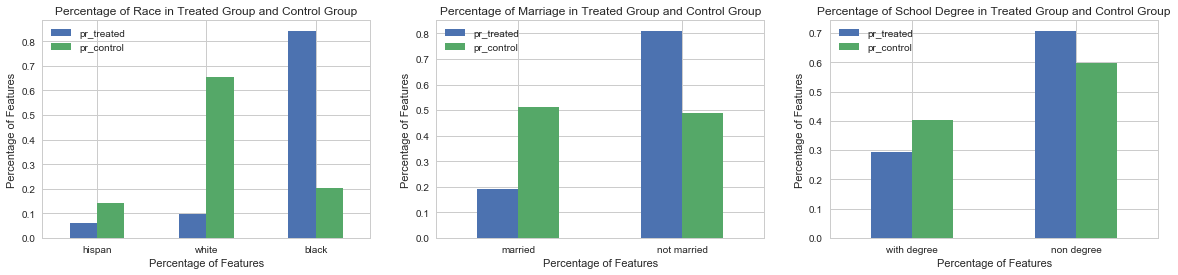

In [18]:
# use predefined function to plot binary features
plot_binary_features_distribution(df_binary_features_pr)

#### Observations of binary features
We see that there is a significant difference in distribution of **"Race"** and **"Married"** features.

#### Plotting Continous Features (age, educ, re74, re75) - Box Plots (without outliers)

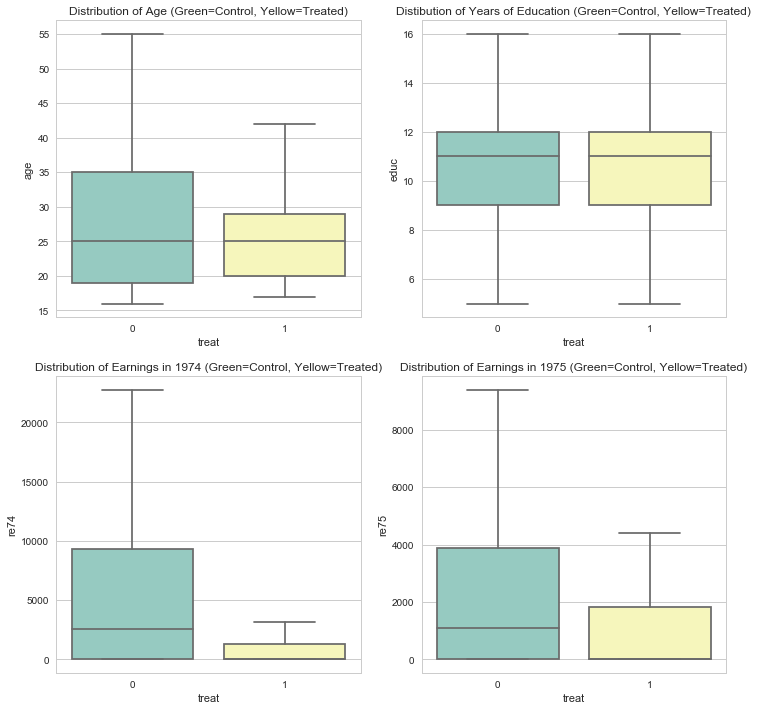

In [19]:
# Plot 2 x 2
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 12)
ax1 = sns.boxplot(y="age", x="treat", ax=ax1, data=df_raw, palette="Set3", showfliers=False)
ax1.set_title("Distribution of Age (Green=Control, Yellow=Treated)")

ax2 = sns.boxplot(y="educ", x="treat", ax=ax2, data=df_raw, palette="Set3", showfliers=False)
ax2.set_title("Distibution of Years of Education (Green=Control, Yellow=Treated)")

ax3 = sns.boxplot(y="re74", x="treat", ax=ax3, data=df_raw, palette="Set3", showfliers=False)
ax3.set_title("Distribution of Earnings in 1974 (Green=Control, Yellow=Treated)")

ax4 = sns.boxplot(y="re75", x="treat", ax=ax4, data=df_raw, palette="Set3", showfliers=False)
ax4.set_title("Distribution of Earnings in 1975 (Green=Control, Yellow=Treated)")

We can sure from boxplot above that there are plenty of zeros present in re74 and re75.
As we see that the mean for treated group is close to zero.

#### Plotting Continous Features (age, educ, re74, re75) - Distribution Plot With Outliers
Disclaimer: Although there are zeros in re74 and re75, we cannot just exclude these values since we assume that job training program made unemployed subjects in 1974 and 1975 gained job in 1978.

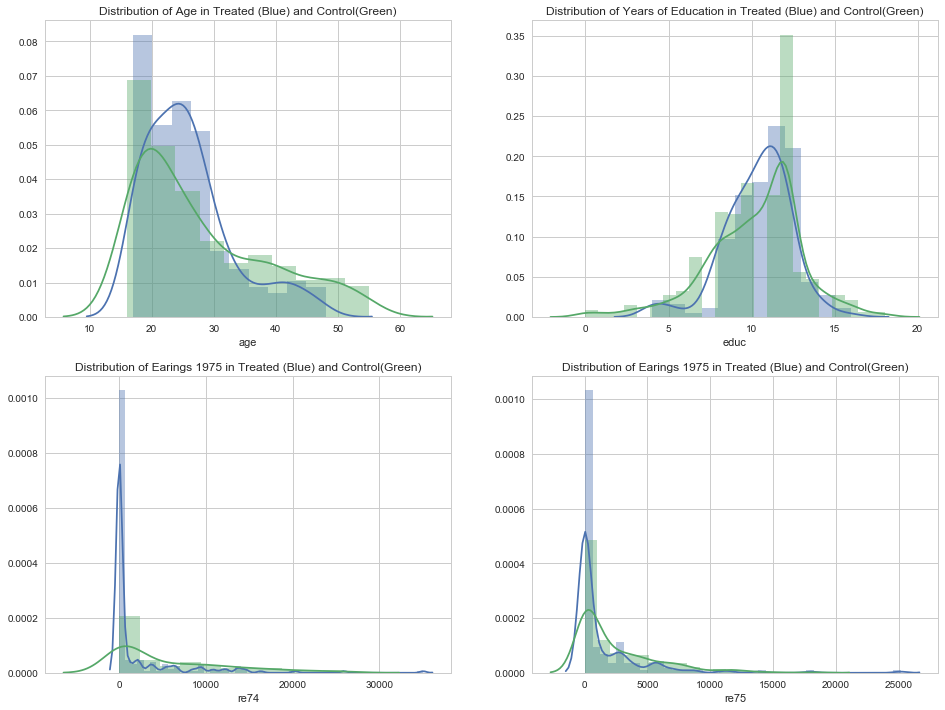

In [20]:
# use our predefined function to plot continuous features-values distribution
plot_continuous_features_distribution(df_treated_raw, df_control_raw)

#### Observations of continuous features
We see that the distribution of continious features between two groups are roughly same. The only obvious imbalance distribution is in feature **"age"**.

#### What does it mean to conclusion we had on previous question?
> In naive/superficial analysis, we compare and draw conclusion for earnings outcome as if we have the identical subjects for both group. For example, we tend to think as if we are comparing an earning outcome of a same person X before and after treatment. 

> We have already known that even the numbers of subjects between two groups are different.
Thus we know that distribution of features are most likely different. We cannot infer the training program does not work without considering underlying factor (features) that might give significant correlation to the earnings outcome.

> Then at this point, we assume that "Race", "Married", "Age" have significant impact to earning outcome and we want to avoid pitfalls in observational studies as we had in 1a.

### 1c. Propensity Score Model
From [Rosenbaum](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf):
<br>
In the population before matching, we imagine that subject received treatment
with probability π, independently of other subjects, where π may vary from one
person to the next and is not known. More precisely, π


\begin{align}
\pi_l & = Pr(Z_l = 1 | r_tl, r_cl, x_l, u_l) \\
\end{align}

Here we define propensity score of each subject is equal to its probability of being treated. To calculate propensity score, we use logistic regression model.

In [21]:
# Now we have eight features; 4 binaries and 4 continuous features
features = ['age','educ','black','hispan','married','nodegree','re74','re75']

# Logistic Regression model
lr = LogisticRegression()

# X = { features }, y = treat
X = df_raw[features]
y = df_raw.treat

# train the model with entire dataset
lr.fit(X, y)

# print the model of our logistic regression
for f in range(len(features)):
    print("{0} * {1} + ".format(lr.coef_[0][f], features[f]))
print(lr.intercept_)

-0.006794203178905679 * age + 
-0.06602229029570279 * educ + 
2.584312591583524 * black + 
-0.0406653837003028 * hispan + 
-0.8414791176919386 * married + 
-0.36073074418825135 * nodegree + 
-7.541712717668056e-05 * re74 + 
5.759223918378022e-05 * re75 + 
[-0.63204746]


$$y = \beta_0 + \beta_1  \times educ + \beta_2  \times black + \beta_3  \times hispan + \beta_4  \times married + \beta_5  \times nodegree + \beta_6  \times re74 + \beta_7  \times re75$$
$$y = -0.6320 - 0.0068 \times age - 0.0660 \times educ + 2.5843  \times black - 0.0407 \times hispan - 0.8415 \times married - 0.3607 \times nodegree - 7.5417 \times re74 + 5.7592 \times re75$$

As we explained before, we use the logistic regression to get probability of being treated for each subject.

In [22]:
# We only pick the probability of being treated by accessing [:,1]
pred = pd.DataFrame(lr.predict_proba(X)[:,1])
pred.columns = ["propensity_score"]
pred.head(5)

,propensity_score
0,0.443350
1,0.144660
2,0.722355
3,0.664151
4,0.698286


Let's split the data again into treated and control group but this time we add **propensity_score** to every subject.

In [23]:
# Create new dataframe, add "propensity_score" column
df_prop_scr                     = df_raw
df_prop_scr['propensity_score'] = pred['propensity_score']

# split the data using predefined split_data function
df_treated_prop_scr, df_control_prop_scr = split_data(df_prop_scr)

display(df_control_prop_scr.head(5))
display(df_treated_prop_scr.head(5))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
185,PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,0.050504
186,PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,0.033330
187,PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,0.022574
188,PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,0.024906
189,PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.416054


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


#### Plotting the distribution of propensity scores

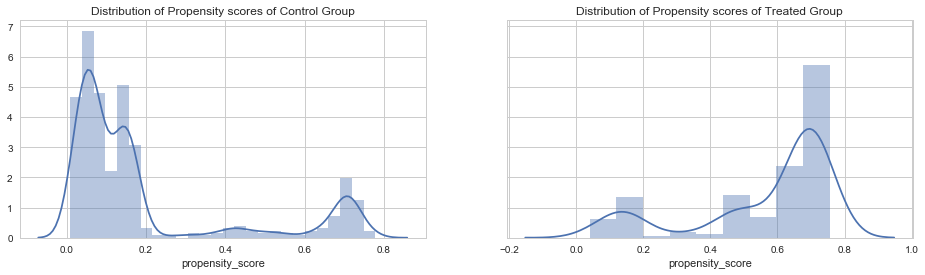

In [24]:
# create 2 x 1 plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 4)
ax1 = sns.distplot(df_control_prop_scr['propensity_score'], ax = ax1)
ax1.set_title("Distribution of Propensity scores of Control Group")

ax2 = sns.distplot(df_treated_prop_scr['propensity_score'], ax = ax2)
ax2.set_title("Distribution of Propensity scores of Treated Group")

#### Observations - Propensity Score Matching with Logistic Regression

> We observe that we are dealing with biased data as some subjects in control group have higher score of getting the treatment and vice versa for some subjects in treated group

### 1d. Balancing dataset via matching Propensity Score
Steps for this part
* Measuring costs between all subjects in treated group with all subjects in control group
* Use networkx graph function to maximize similiarity between matched subjects.
* Data wrangling
* Analysis of re78 after matching
* Analysis of features-values distribution after matching

#### Costs
We define cost as:
$$cost_{ij} = | PropensityScore_i - PropensityScore_j |$$

Where; i = subject i from either control or treated group, j = subject in different group from i.

For each subject from treated group, we measure its costs to every datapoint in control group.

In [25]:
# Init an empty dataframe
df_pr_costs = pd.DataFrame()

# Loop through each subject in control group.
for row in df_control_prop_scr[['id','propensity_score']].iterrows():
    # get subject id and subject propensity score
    subject_id     = row[1][0]
    subject_pr_scr = row[1][1]
    
    # measure absolute costs from all subject in treated group to this control subject
    costs               = abs(subject_pr_scr - df_treated_prop_scr.propensity_score)
    
    # form dataframe contains: "0" source, "b" destination, "costs" of "0"-"b"
    df_pr_cost          = pd.DataFrame(df_treated_prop_scr[['id']])
    df_pr_cost.columns  = [['b']]
    df_pr_cost['0']     = subject_id
    df_pr_cost["costs"] = pd.DataFrame(costs) 
    
    # append distance per subject
    df_pr_costs           = pd.concat([df_pr_costs, df_pr_cost])

print("Dataframe with costs:")
display(df_pr_costs.head(5))

Dataframe with costs:


,b,0,costs
0,NSW1,PSID1,0.392846
1,NSW2,PSID1,0.094156
2,NSW3,PSID1,0.671851
3,NSW4,PSID1,0.613647
4,NSW5,PSID1,0.647782


#### Matching with Networkx Graph
To ensure that each data point from the control group is matched with at most one data point from the treated group, we use networkx package.

In [26]:
# Perform max weight matching using our predefined function
df_prop_matched = graph_matching(df_pr_costs)

print("Matched control-treated subject:")
df_prop_matched.head()

Matched control-treated subject:


,control,treated
1,PSID429,NSW1
19,PSID420,NSW10
199,PSID330,NSW100
201,PSID329,NSW101
203,PSID328,NSW102


#### Data wrangling
Finally, we add corresponding values of re78 to each pair of control-treated subject.

In [27]:
# set "id" as index of df_raw, form new dataframe
df_raw_indexed = df_raw.set_index("id")

# Get value of re78 each matched control-treated subject
re78_control = df_raw_indexed.loc[df_prop_matched["control"]]["re78"]
re78_treated = df_raw_indexed.loc[df_prop_matched["treated"]]["re78"]

# add the re78 into df_prop_matched
df_prop_matched["re78_control"] = list(re78_control)
df_prop_matched["re78_treated"] = list(re78_treated)

print("Matched control-treated subject with their corresponding re78 value")
df_prop_matched.head()

Matched control-treated subject with their corresponding re78 value


,control,treated,re78_control,re78_treated
1,PSID429,NSW1,1495.4590,9930.046
19,PSID420,NSW10,964.9555,12418.070
199,PSID330,NSW100,116.7404,26817.600
201,PSID329,NSW101,1717.1180,0.000
203,PSID328,NSW102,14339.8600,9265.788


#### Analysis of re78 after propensity score matching
To get brief stats, we compare using descibe()

In [28]:
df_prop_matched.describe()

,re78_control,re78_treated
count,185.000000,185.000000
mean,5525.962462,6349.143530
std,6637.979050,7867.402218
min,0.000000,0.000000
25%,0.000000,485.229800
50%,2813.591000,4232.309000
75%,8844.194000,9642.999000
max,25564.670000,60307.930000


##### Plotting Distribution of re78 between two groups after propensity score matching
Note that we don't include outliers in plot below.

Average earning of Control group :  5525.962462378378
Median earning of Control group :  2813.591
Average earning of Treated group :  6349.1435302702685
Median earning of Treated group :  4232.309


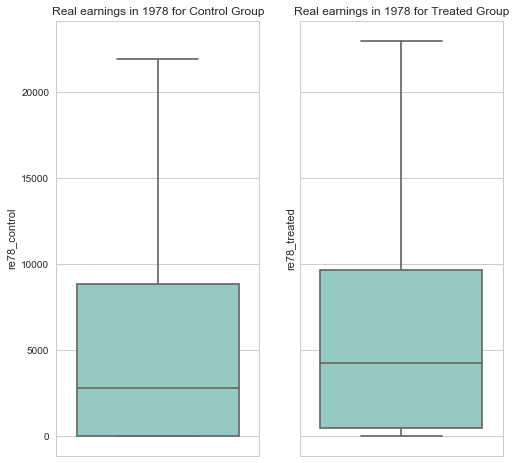

In [29]:
# draw distribution of outcomes (re78) using our predefined functions
plot_re78_distribution(df_prop_matched)

##### Observations of re78 values
We can spot that after the matching, the treated group has higher mean, median, and 25% quartile. This means at this point, we can show that the earnings outcome of treated group is better than control group.
> We conclude at this point that the training is working and effective

#### Analysis of features-values distribution after propensity score matching
Now we repeat our result in task 1b but using matched data of control-treated subjects. This is necessary to observe features distribution between matched control and treated group.

In [30]:
# Get only matched control-treated pair from raw dataframe
df_control = df_raw_indexed.loc[df_prop_matched["control"]]
df_treated = df_raw_indexed.loc[df_prop_matched["treated"]]

# note that n_treated should be equal to n_control
n_treated = df_treated.shape[0]
n_control = df_control.shape[0]

# Check how many pairs we have
print("Number of treated subject: ",n_treated)
print("Number of control subject: ",n_control)

# Display pairs-example
display(df_control.head(3))
display(df_treated.head(3))

Number of treated subject:  185
Number of control subject:  185


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
PSID429,0,16,9,0,0,0,1,0.00,0.0,1495.4590,0.155030
PSID420,0,39,2,1,0,1,1,0.00,0.0,964.9555,0.587354
PSID330,0,22,16,1,0,0,0,2564.68,0.0,116.7404,0.634835


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046,0.443350
NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.070,0.076562
NSW100,1,31,9,0,1,0,1,0.0,0.0,26817.600,0.137257


###### Binary Features (race, married, nodegree)

In [31]:
# use predefined function to get dataframe of percentage of each binary feature in dataset
df_binary_features_pr = get_binary_features_distribution(df_treated, df_control)

Number of Black Subject in Treated Group:  156
Number of Black Subject in Control Group:  51
Number of White Subject in Treated Group After Matching:  18
Number of White Subject in Control Group After Matching:  112
Number of Hispan Subject in Treated Group:  11
Number of Hispan Subject in Control Group:  22
Number of Married Subject in Treated Group:  35
Number of Married Subject in Control Group:  76
Number of Nodegree Subject in Treated Group:  131
Number of Nodegree Subject in Control Group:  121


,features,pr_treated,pr_control
0,black,0.843243,0.275676
1,hispan,0.059459,0.118919
2,white,0.097297,0.605405


,features,pr_treated,pr_control
3,married,0.189189,0.410811
4,not married,0.810811,0.589189


,features,pr_treated,pr_control
5,non degree,0.708108,0.654054
6,with degree,0.291892,0.345946


###### Plotting Distribution of Binary Features (race, married, nodegree) after propensity score matching

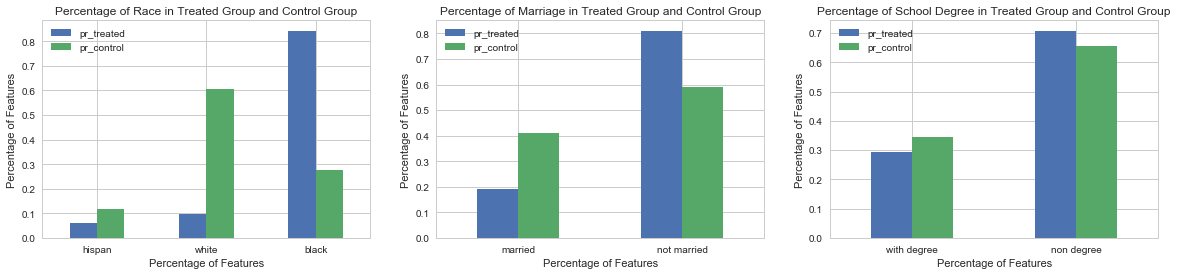

In [32]:
# use predefined function to plot binary features
plot_binary_features_distribution(df_binary_features_pr)

###### Observations of binary features
> After matching, the distibutions of **race** and **married** still have huge differences. At this point we have to **withdraw our previous conclusion** as we cannot infer the result of observational studies in which treatment assignment and response may be caused by featues correlate (black or married).

###### Plotting Distribution of Continous Features (age, educ, re74, re75) after propensity score matching:  Distribution Plot With Outliers

**Disclaimer about zeros in re74 and re75**: Although there are zeros in re74 and re75, we cannot just exclude these values since we **assume** that job training program made unemployed subjects in 1974 and 1975 gained job in 1978.

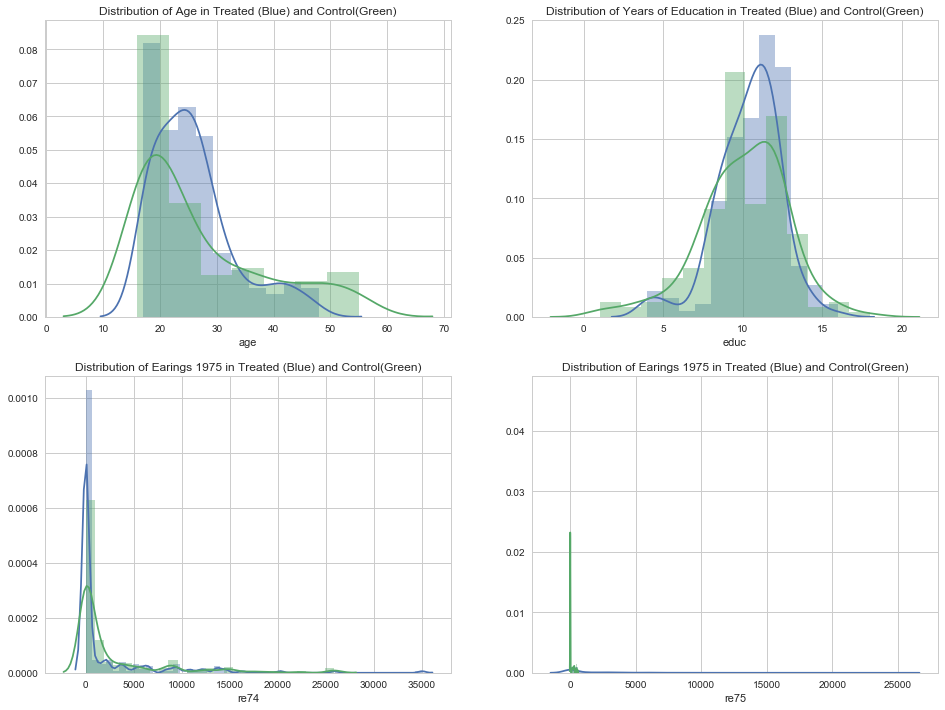

In [33]:
# use our predefined function to plot continuous features-values distribution
plot_continuous_features_distribution(df_treated, df_control)

###### Observations of Continuous features
> We can see that there is no significance difference of distribution between continuous features, before and after matching. After matching we notice that the distribution of continuous features between two groups are roughly same. Consistenly, the only obvious imbalance distribution is in feature **"age"**, same as before matching.

#### 1d recap: We are not satisfied with the result! :(
> After propensity score matching, we still are not happy with the results since the features distribution are not well-balanced. Let's say that training program is well-suited for Husbands (married) to manage work-life balanced or the training is designed to white (non-black) people only. This will mislead our conclusion and it's better if we try to balance the distribution even further, as we are not sure the implication of underlying features!

### 1e. Balancing Groups Further: Binary Features Matching
From the results obtained by 1b and 1d, we can see from the plots that two binaries features are heavily imbalanced; race and married. We aware that the ages distribution is not suifficiently balanced as well. But out strategy is to  pay more attention to "**black**" and "**married**" feature.

Almost the same as 1d, steps for this part:
* Measuring costs between all subjects in treated group with all subjects in control group
* Use networkx graph function to maximize similiarity between matched subjects.
* Data wrangling
* Analysis of features-values distribution after matching

> We use suffix \_fm (final matching) to distinguish variable names in this part and onwards with previous ones. 

#### Costs
Important notes: 
* Now we cut the node connections if subject in control does not has the same property as subject in treatment. E.g. for a subject i in control, who is black, we measure costs only between it to other black subjects in treatment group. 
* We filter "black" and "married" features only.

In [34]:
# Init an empty dataframe: costs of propensity scores between matched features only
df_matched_f_pr_costs = pd.DataFrame()

# Loop through each subject in control group.
for row in df_control_prop_scr[['id','propensity_score','black','married']].iterrows():
    # get subject id and subject propensity score
    subject_id     = row[1][0]
    subject_pr_scr = row[1][1]
    
    # get black and married property of the control subject
    subject_black   = row[1][2]
    subject_married = row[1][3]
    
    # measure absolute costs from all subject in treated group to this control subject
    costs = abs(subject_pr_scr - df_treated_prop_scr.loc[(df_treated_prop_scr["black"] == subject_black ) \
                                                         & (df_treated_prop_scr["married"] == subject_married)]
                                                        .propensity_score)
    
    # form dataframe contains: "0" source, "b" destination, "costs" of "0"-"b"
    df_pr_cost          = pd.DataFrame(df_treated_prop_scr[['id']])
    df_pr_cost.columns  = [['b']]
    df_pr_cost['0']     = subject_id
    df_pr_cost["costs"] = pd.DataFrame(costs) 
    
    # append distance per subject
    df_matched_f_pr_costs           = pd.concat([df_matched_f_pr_costs, df_pr_cost.dropna(axis=0)])

print("Dataframe with costs:")
display(df_matched_f_pr_costs.head(5))

Dataframe with costs:


,b,0,costs
9,NSW10,PSID1,0.026058
43,NSW44,PSID1,0.023593
123,NSW124,PSID1,0.010333
136,NSW137,PSID1,0.031153
166,NSW167,PSID1,0.005501


#### Matching with Networkx Graph
To ensure that each data point from the control group is matched with at most one data point from the treated group, we use networkx package.

In [35]:
# Perform max weight matching using our predefined function
df_prop_fm = graph_matching(df_matched_f_pr_costs)

print("Matched control-treated subject:")
df_prop_fm.head()

Matched control-treated subject:


,control,treated
3,PSID428,NSW1
7,PSID426,NSW10
55,PSID402,NSW100
59,PSID400,NSW11
203,PSID98,NSW110


#### Data wrangling
Finally, we add corresponding values of re78 to each pair of control-treated subject.

In [36]:
# Get value of re78 each matched control-treated subject
re78_control = df_raw_indexed.loc[df_prop_fm["control"]]["re78"]
re78_treated = df_raw_indexed.loc[df_prop_fm["treated"]]["re78"]

# add the re78 into df_prop_matched
df_prop_fm["re78_control"] = list(re78_control)
df_prop_fm["re78_treated"] = list(re78_treated)

print("Matched control-treated subject with their corresponding re78 value")
df_prop_fm.head()

Matched control-treated subject with their corresponding re78 value


,control,treated,re78_control,re78_treated
3,PSID428,NSW1,187.6713,9930.046
7,PSID426,NSW10,19464.6100,12418.070
55,PSID402,NSW100,0.0000,26817.600
59,PSID400,NSW11,648.7220,8173.908
203,PSID98,NSW110,0.0000,0.000


**Note that we will use df_prop_fm for final part 1f**

#### Analysis of features-values distribution after propensity score matching + binary features matching
Now we confirm the distribution of features in our matched dataset control and treated group.

In [37]:
# Get only matched control-treated pair from raw dataframe
df_control_fm = df_raw_indexed.loc[df_prop_fm["control"]]
df_treated_fm = df_raw_indexed.loc[df_prop_fm["treated"]]

# note that n_treated should be equal to n_control
n_treated_fm = df_treated_fm.shape[0]
n_control_fm = df_control_fm.shape[0]

# Check how many pairs we have
print("Number of treated subject: ",n_treated_fm)
print("Number of control subject: ",n_control_fm)

# Display pairs-example
display(df_control_fm.head(3))
display(df_treated_fm.head(3))

Number of treated subject:  116
Number of control subject:  116


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713,0.550460
PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100,0.108708
PSID402,0,16,8,0,0,0,1,0.0,0.0,0.0000,0.163876


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046,0.443350
NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.070,0.076562
NSW100,1,31,9,0,1,0,1,0.0,0.0,26817.600,0.137257


> Note that we have less number of matched treated-control subject in dataset. Now we have **116 out of 185** pairs subject in maximum.

###### Binary Features (race, married, nodegree) after Features + Propensity score matching
Recall that we use suffix \_fm (final matching) to distinguish variable names in this part with previous ones. 

Now we form dataframe consisting percentages of each binary features

In [38]:
# use predefined function to get dataframe of percentage of each binary feature in dataset
df_pr_binary_features_fm = get_binary_features_distribution(df_treated_fm, df_control_fm)

Number of Black Subject in Treated Group:  87
Number of Black Subject in Control Group:  87
Number of White Subject in Treated Group After Matching:  18
Number of White Subject in Control Group After Matching:  24
Number of Hispan Subject in Treated Group:  11
Number of Hispan Subject in Control Group:  5
Number of Married Subject in Treated Group:  31
Number of Married Subject in Control Group:  31
Number of Nodegree Subject in Treated Group:  80
Number of Nodegree Subject in Control Group:  74


,features,pr_treated,pr_control
0,black,0.750000,0.750000
1,hispan,0.094828,0.043103
2,white,0.155172,0.206897


,features,pr_treated,pr_control
3,married,0.267241,0.267241
4,not married,0.732759,0.732759


,features,pr_treated,pr_control
5,non degree,0.689655,0.637931
6,with degree,0.310345,0.362069


###### Plotting Distribution of Binary Features (race, married, nodegree) after features + propensity score matching

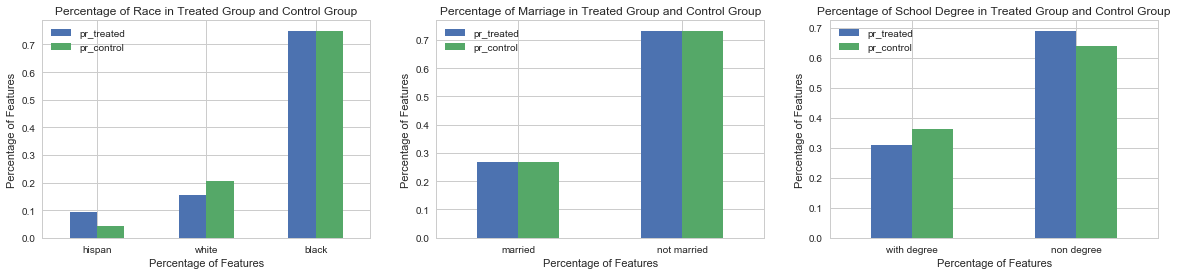

In [39]:
# use predefined function to plot binary features
plot_binary_features_distribution(df_pr_binary_features_fm)

###### Observations of binary features :)
> Now we are happy about the balanced distribution of binary features between treated and control group. We can give toleration to the rest features; nodegree and hispan. Because if we want the distibution to be exactly the same, we will reduce the number of datapoints and yet we have only 116 out of 185 (62%). Therefore we are satisfied with our distribution of binary features.

###### Plotting Distribution of Continous Features (age, educ, re74, re75) after features + propensity score matching:  Distribution Plot With Outliers

**Disclaimer about zeros in re74 and re75**: Although there are zeros in re74 and re75, we cannot just exclude these values since we **assume** that job training program made unemployed subjects in 1974 and 1975 gained job in 1978.

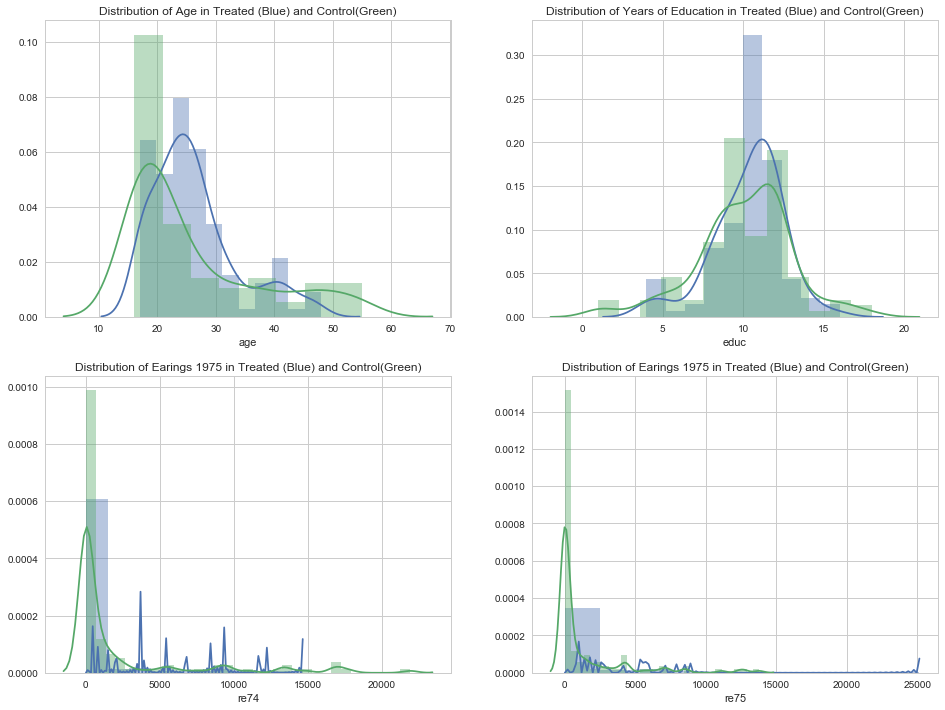

In [40]:
# use our predefined function to plot continuous features-values distribution
plot_continuous_features_distribution(df_treated_fm, df_control_fm)

###### Observations of Continuous features ?
We are a little bit disappointed with distribution of "age" which is quite imbalance after all features and propensity score matching that we have done. However, as we have explained before, we decide to focus more on binary features "black" and "married" as they had huge imbalance distribution between control and treated group. 
* If we want to balance the "age" distribution we may end up with a few data point (maybe less than 50%) and thus we don't want to draw conclusions using less than 50% data of maximum pairs of subject.

> To sum up, now we are satisfied with out final matching pair of treated and control group since we have better balanced features-values distribution, regardless of the only "age" quite imbalance distribution. We jump to next step with our final dataframe result "df_prop_fm" in order to draw the conclusion of this observational studies.

### 1f. A less naive analysis
Now we compare the outcomes (re78) between treated and control group using number and plots.
We use very final version of matching treated-control subject (result from 1e), namely "df_prop_fm"

In [41]:
# To get brief stats, we compare using descibe()
df_prop_fm.describe()

,re78_control,re78_treated
count,116.000000,116.000000
mean,4837.325071,6220.832549
std,6321.256830,6408.060991
min,0.000000,0.000000
25%,0.000000,733.987100
50%,1514.669500,4277.007000
75%,7641.324000,9970.742000
max,23764.800000,26817.600000


###### Plotting the outcomes (re78) for control and treated group after final matching

Average earning of Control group :  4837.325071120689
Median earning of Control group :  1514.6695
Average earning of Treated group :  6220.832549137933
Median earning of Treated group :  4277.007


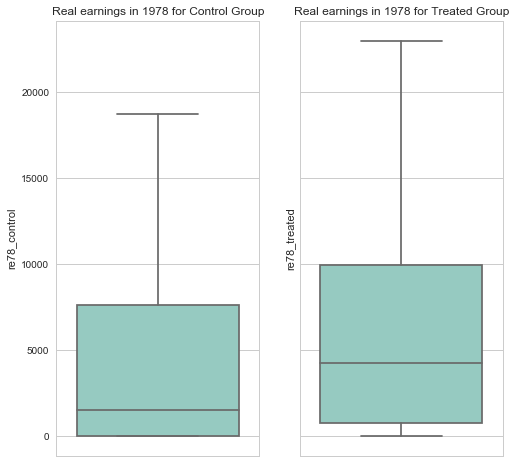

In [42]:
# draw distribution of outcomes (re78) using our predefined functions
plot_re78_distribution(df_prop_fm)

#### Conclusion of the observational studies on job training program
> We can observe directly from plot above that outcome earnings (re78) for subjects in treated group are larger than those in control group. Mean, median, 25% percentile, of treated group are generally larger than control group. The increase in average earnings is: 

$$(6220.832-4837.325)/4837.325 = 28.60\%$$ 

> Consequently, we conclude that **the job training program is genuinely effective to increase indivindual's earnings**.

## 2. Applied ML

#### Problem description
We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.





### Data collection
![figure](data_collection.PNG)
#### Steps in data collection
1. load the whole dataset
2. vectorize the news category with [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
3. split the data into 80% training set, 10% test set and 10% validation set <br />
   we use function **train_test_split** to split 80% training set and 20% test set firstly, then use the function again to split test set into 10% test set and 10% validation set

#### Note
Because we are going to use random forest, we don't need to perform standardization on the features

In [43]:
# load the whole dataset
newsgroups = fetch_20newsgroups(subset='all')

# vectorize the dataset with TF-IDF
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

# split the original dataset into 20% validation set, 10% test set and 80% training set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# split the test set into 50% validation set and 50% test set (both are 10% of the original dataset)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)


### Model selection
![figure](model_selection.PNG)
#### Random forest
As required, we select random forest and use grid search to find the best parameters for 
- n_estimators : number of decision trees
- max_depth &nbsp; &nbsp;: depth of each tree

We constrain our max_depth upto 30 and n_estimator upto 1500, and we also test on several setting in other arguments such as min_samples_leaf and max_features, but we find that the default setting has the best performance:

| argument         | range              |
|------------------|--------------------|
| n_estimator      | 100 - 1500      |
| max_depth        | 10, 20, 30 |
| max_features     | default: "sqrt"    |
| min_samples_leaf | default: 1         |


#### Evaluation metric
We use the function [f1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) to evaluate the performance of classifier because it considers both metrics **accuracy** and **recall**. 


#### Note
In this part we don't use cross validation during grid search. Based on the requirement of 80% training set and 10% test set, we need to perform 9-fold cross-validation and it would take a huge amount of time when n_estimators and max_depth are large. Our concern is the execution time, so we use same validation set and training set to evaluate the metric. Overfitting can actually be avoided by increasing n_estimators, and therefore cross validation is not really necessary here.



#### Grid search

In [44]:
# variables to store the best parameters and model
best_fscore_tr = fscore = best_fscore = best_n_estimators = best_max_depth = 0

n1 = 15
n2 = 3

n_estimators_arr = [i*100 + 100 for i in range(n1)]
max_depth_arr = [i*10 + 10 for i in range(n2)]
fscore_test_array = np.zeros([n1,n2])
fscore_train_array = np.zeros([n1,n2])

# grid search the best parameters
for i, n_estimators in enumerate(n_estimators_arr):
    for j, max_depth in enumerate(max_depth_arr):

        # build the model and train
        clf = RandomForestClassifier(n_estimators=n_estimators, 
                                     max_depth=max_depth,
                                     n_jobs=4)
        clf.fit(x_train, y_train)

        # test the performance with validation set
        # 'macro' means calculating metrics for each label, and finding their unweighted mean
        fscore = fscore_test_array[i,j] = f1_score(y_val, clf.predict(x_val), average = 'macro')
        fscore_train_array[i,j] = f1_score(y_train, clf.predict(x_train), average = 'macro')
        
        # record the best one
        if fscore > best_fscore:
            best_fscore = fscore
            best_fscore_tr = fscore_train_array[i,j]
            best_n_estimators = n_estimators 
            best_max_depth = max_depth
            best_model = clf
            
print('best n_estimators            :', n_estimators)
print('best max_depth               :', max_depth)
print('best training f1 score       :', best_fscore_tr)
print('best validation f1 score     :', best_fscore)
print('test f1 score                :', f1_score(y_test, best_model.predict(x_test), average = 'macro'))


best n_estimators            : 1500
best max_depth               : 30
best training f1 score       : 0.963359670382
best validation f1 score     : 0.820256017162
test f1 score                : 0.828461798802


#### Learning curve
Let's see how f1 score in test set and training set move with n_estimator and max_depth

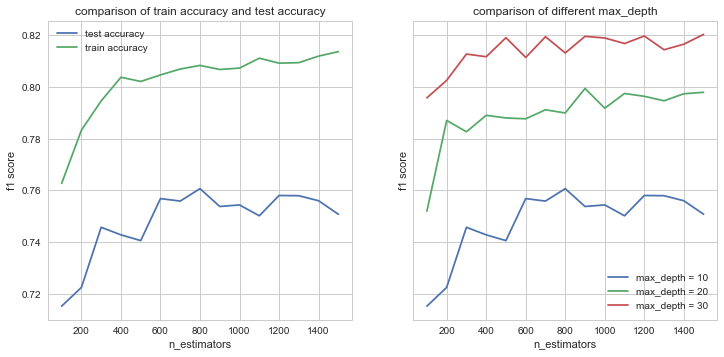

In [45]:
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)
f.set_figwidth(12)
ax1.plot(n_estimators_arr, fscore_test_array[:,0], label = 'test accuracy')
ax1.plot(n_estimators_arr, fscore_train_array[:,0], label = 'train accuracy')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('f1 score')
ax1.set_title('comparison of train accuracy and test accuracy')
ax1.legend()

ax2.plot(n_estimators_arr, fscore_test_array[:,0], label = 'max_depth = 10')
ax2.plot(n_estimators_arr, fscore_test_array[:,1], label = 'max_depth = 20')
ax2.plot(n_estimators_arr, fscore_test_array[:,2], label = 'max_depth = 30')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('f1 score')
ax2.set_title('comparison of different max_depth')
ax2.legend()

plt.show()

Comment: We could see usually the higher the n_estimator and max_depth are, the better the accuracy is. However, the accuracy is only improved a little bit when n_estimator is larger than 400.

#### Confusion matrix
By definition from [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

Confusion matrix $C$ is such that $C_{ij}$ is equal to to the number of observations known to be in group $i$ but predicted to be in group $j$. Hence for each category i:

####  <center>$accuracy = {{C_{ii}}\over{\sum_{j}C_{ij}}}, recall = {{C_{ii}}\over{\sum_{j}C_{ji}}}$</center>


Now, let's plot confusion matrix to visualize the performance of our model.

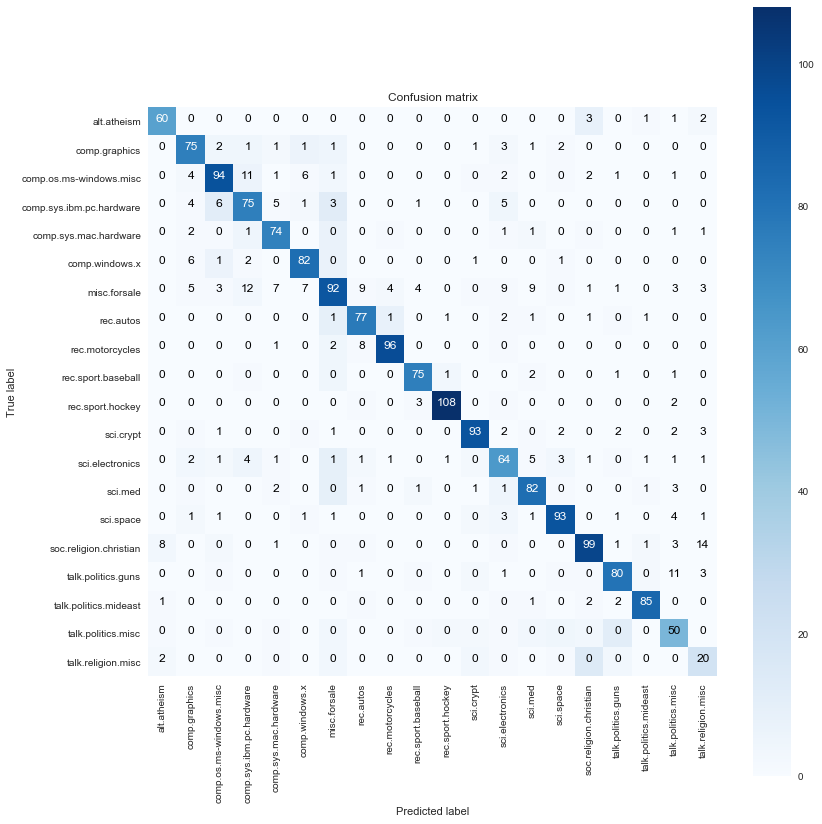

In [46]:
# create confusion matrix
sns.set(style="dark")
cnf_matrix = confusion_matrix(y_test, best_model.predict(x_test))

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Function to plot confusion matrix
    Args:
        cm          : confusion matrix
        classes     : array storing the name of categories
        camp        : color bar of confusion matrix
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot the confusion matrix
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, 
                      classes=newsgroups.target_names,
                      title='Confusion matrix')
plt.show()

Comment: We can see if we use f1 score as our metric, usually both accracy and recall are low because f1 score is the harmonic mean of them. Here we can only see the classification of misc.forsale is worse

### Model assessment
![figure](model_assessment.PNG)
#### Cross-validation
To assess our model based on best n_estimator and max_depth got from grid search, we perform 10-fold cross validation on our best model. Note that this time we use all the data to train random forest because we are sure that the parameters we choose do not cause overfit (i.e. test accuracy and train accuracy are nearly the same in previous result). Hence, the more the data, the better the model is.

In [47]:
def build_k_indices(y, k_fold):
    """Function to build k indices for k-fold.

    Args:
        y      (numpy array): Matrix output of size N x 1.
        k_fold (int)        : The value k, of k-fold cross validation.
        seed   (int)        : Integer value to seed the random generator.

    Returns:
        k_indices (numpy array) : Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
    """
    seed = 1
    num_row    = y.shape[0]
    interval   = int(num_row / k_fold)
    np.random.seed(seed)
    indices    = np.random.permutation(num_row)
    k_indices  = np.array([indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)])
    return k_indices

def data_split(y, x, k_indices, k):
    """Function to split training data and test data using K-cross validation based on given k_indices.

    Args:
        y         (numpy array): Matrix output of size N x 1.
        tx        (numpy array): Matrix input of size N x D.
        k_indices (numpy array): Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
        k         (int)        : For choosing index in the k_indices

    Returns:
        x_train (numpy array) : Matrix input (features) for training set with size of (ratio*N) x D.
        y_train (numpy array) : Matrix output for training set with size of (ratio*N) x 1.
        x_test  (numpy array) : Matrix input (features) for testing set with size of ((1-ratio)*N) x D.
        y_test  (numpy array) : Matrix output for testing set with size of ((1-ratio)*N) x 1.
    """
    
    train_set_indices               = np.ones(x.shape[0], dtype = bool)
    train_set_indices[k_indices[k]] = False

    x_train = x[train_set_indices]
    y_train = y[train_set_indices]
    
    x_test  = x[k_indices[k]]
    y_test  = y[k_indices[k]]
    
    return x_train, y_train, x_test, y_test



# build validation set
k_fold = 10
k_indices = build_k_indices(newsgroups.target, k_fold)

best_n_estimators = 1500
best_max_depth = 30

# best classifier from grid search
clf = RandomForestClassifier(n_estimators=best_n_estimators, 
                             max_depth=best_max_depth,
                             n_jobs=4)

accuracy_arr = np.zeros(k_fold)
para_ = []
# perform 10-fold cross validation
for k in range(k_fold):
    x_train, y_train, x_test, y_test = data_split(y = y, x = x, k_indices=k_indices, k=k)
    clf.fit(x_train, y_train)
    accuracy_arr[k] = f1_score(y_test, clf.predict(x_test), average = 'macro')
    para_.append(clf.feature_importances_)
print('average f1 score = ', np.mean(accuracy_arr))

average f1 score =  0.815357300641


#### Observe feature_importance
We can see there're lots of useless features (feature_importance = 0)


And we observe the value of non-zero features in log scale and plot it in histogram. Based on the histogram, we could see the majority of feature importance is really small, and we think there're two reasons. The first reason is that there exists lots of useless features, and the second reason is that there're too many features and makes the importance of each feature decrease. 

total number of features: 173762
number of features with importance: 48165


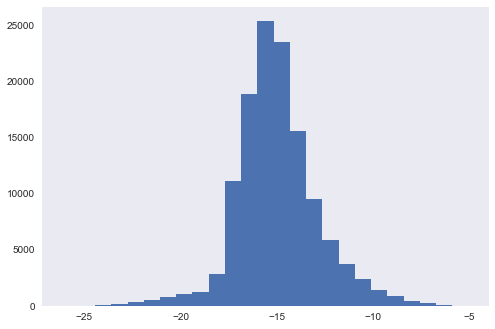

In [48]:
feature_importance = np.mean(para_, axis=0)

print('total number of features:', feature_importance.shape[0])
# number of 0's in the feature importance
print('number of features with importance:', np.sum(feature_importance == 0))

# let's see features with non-zero value in log scale
plt.hist(np.log(feature_importance[feature_importance != 0]), bins = 25)
plt.show()